In [1]:
!pip install sentence-transformers
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [3]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [4]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [5]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [6]:
data = data.dropna()

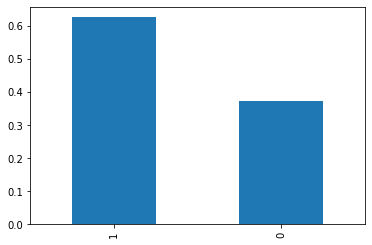

In [7]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [8]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [9]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [10]:
len(train_data)*0.25, type(train_labels), train_labels.shape


(802.0, numpy.ndarray, (3208,))

In [11]:
train_data = train_data.iloc[0:802]
train_labels = train_labels[0:802]

In [12]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 802, 802)

In [13]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [14]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [15]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples)

In [16]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

In [17]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [18]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [19]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 22:05:10 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-06 22:05:11 - Use pytorch device: cuda
2022-09-06 22:05:11 - Softmax loss: #Vectors concatenated: 3
51


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 22:05:19 - Accuracy with Cosine-Similarity:           73.94	(Threshold: 0.4318)
2022-09-06 22:05:19 - F1 with Cosine-Similarity:                 81.62	(Threshold: 0.4071)
2022-09-06 22:05:19 - Precision with Cosine-Similarity:          73.19
2022-09-06 22:05:19 - Recall with Cosine-Similarity:             92.25
2022-09-06 22:05:19 - Average Precision with Cosine-Similarity:  86.91

2022-09-06 22:05:19 - Accuracy with Manhattan-Distance:           74.19	(Threshold: 349.6080)
2022-09-06 22:05:19 - F1 with Manhattan-Distance:                 82.04	(Threshold: 371.3835)
2022-09-06 22:05:19 - Precision with Manhattan-Distance:          72.52
2022-09-06 22:05:19 - Recall with Manhattan-Distance:             94.43
2022-09-06 22:05:19 - Average Precision with Manhattan-Distance:  87.45

2022-09-06 22:05:19 - Accuracy with Euclidean-Distance:           74.31	(Threshold: 15.8637)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:23 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 22:05:24 - Accuracy with Cosine-Similarity:           76.81	(Threshold: 0.4361)
2022-09-06 22:05:24 - F1 with Cosine-Similarity:                 82.99	(Threshold: 0.2772)
2022-09-06 22:05:24 - Precision with Cosine-Similarity:          72.51
2022-09-06 22:05:24 - Recall with Cosine-Similarity:             97.02
2022-09-06 22:05:24 - Average Precision with Cosine-Similarity:  88.96

2022-09-06 22:05:24 - Accuracy with Manhattan-Distance:           76.43	(Threshold: 351.5850)
2022-09-06 22:05:24 - F1 with Manhattan-Distance:                 83.19	(Threshold: 405.3092)
2022-09-06 22:05:24 - Precision with Manhattan-Distance:          73.73
2022-09-06 22:05:24 - Recall with Manhattan-Distance:             95.43
2022-09-06 22:05:24 - Average Precision with Manhattan-Distance:  89.17

2022-09-06 22:05:24 - Accuracy with Euclidean-Distance:           76.68	(Threshold: 16.4800)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:29 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 22:05:29 - Accuracy with Cosine-Similarity:           78.30	(Threshold: 0.3507)
2022-09-06 22:05:29 - F1 with Cosine-Similarity:                 83.96	(Threshold: 0.3054)
2022-09-06 22:05:29 - Precision with Cosine-Similarity:          76.77
2022-09-06 22:05:29 - Recall with Cosine-Similarity:             92.64
2022-09-06 22:05:29 - Average Precision with Cosine-Similarity:  90.02

2022-09-06 22:05:29 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 394.9673)
2022-09-06 22:05:29 - F1 with Manhattan-Distance:                 84.01	(Threshold: 396.2942)
2022-09-06 22:05:29 - Precision with Manhattan-Distance:          78.88
2022-09-06 22:05:29 - Recall with Manhattan-Distance:             89.86
2022-09-06 22:05:29 - Average Precision with Manhattan-Distance:  90.16

2022-09-06 22:05:29 - Accuracy with Euclidean-Distance:           78.43	(Threshold: 17.5156)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 22:05:34 - Accuracy with Cosine-Similarity:           77.68	(Threshold: 0.3085)
2022-09-06 22:05:34 - F1 with Cosine-Similarity:                 83.83	(Threshold: 0.1504)
2022-09-06 22:05:34 - Precision with Cosine-Similarity:          73.57
2022-09-06 22:05:34 - Recall with Cosine-Similarity:             97.42
2022-09-06 22:05:34 - Average Precision with Cosine-Similarity:  90.11

2022-09-06 22:05:34 - Accuracy with Manhattan-Distance:           78.30	(Threshold: 410.0159)
2022-09-06 22:05:34 - F1 with Manhattan-Distance:                 83.90	(Threshold: 460.0889)
2022-09-06 22:05:34 - Precision with Manhattan-Distance:          73.68
2022-09-06 22:05:34 - Recall with Manhattan-Distance:             97.42
2022-09-06 22:05:34 - Average Precision with Manhattan-Distance:  90.19

2022-09-06 22:05:34 - Accuracy with Euclidean-Distance:           78.05	(Threshold: 18.7125)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:39 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 22:05:40 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.3013)
2022-09-06 22:05:40 - F1 with Cosine-Similarity:                 83.96	(Threshold: 0.3013)
2022-09-06 22:05:40 - Precision with Cosine-Similarity:          79.09
2022-09-06 22:05:40 - Recall with Cosine-Similarity:             89.46
2022-09-06 22:05:40 - Average Precision with Cosine-Similarity:  90.37

2022-09-06 22:05:40 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 421.2029)
2022-09-06 22:05:40 - F1 with Manhattan-Distance:                 84.34	(Threshold: 421.2029)
2022-09-06 22:05:40 - Precision with Manhattan-Distance:          78.99
2022-09-06 22:05:40 - Recall with Manhattan-Distance:             90.46
2022-09-06 22:05:40 - Average Precision with Manhattan-Distance:  90.37

2022-09-06 22:05:40 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 18.7026)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 22:05:45 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.2805)
2022-09-06 22:05:45 - F1 with Cosine-Similarity:                 83.83	(Threshold: -0.0148)
2022-09-06 22:05:45 - Precision with Cosine-Similarity:          73.57
2022-09-06 22:05:45 - Recall with Cosine-Similarity:             97.42
2022-09-06 22:05:45 - Average Precision with Cosine-Similarity:  89.82

2022-09-06 22:05:45 - Accuracy with Manhattan-Distance:           78.68	(Threshold: 436.1821)
2022-09-06 22:05:45 - F1 with Manhattan-Distance:                 84.11	(Threshold: 444.2760)
2022-09-06 22:05:45 - Precision with Manhattan-Distance:          78.16
2022-09-06 22:05:45 - Recall with Manhattan-Distance:             91.05
2022-09-06 22:05:45 - Average Precision with Manhattan-Distance:  89.85

2022-09-06 22:05:45 - Accuracy with Euclidean-Distance:           78.93	(Threshold: 19.8115)
2022-09-06 22:05

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:49 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 22:05:50 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.2177)
2022-09-06 22:05:50 - F1 with Cosine-Similarity:                 84.30	(Threshold: 0.2177)
2022-09-06 22:05:50 - Precision with Cosine-Similarity:          78.33
2022-09-06 22:05:50 - Recall with Cosine-Similarity:             91.25
2022-09-06 22:05:50 - Average Precision with Cosine-Similarity:  89.51

2022-09-06 22:05:50 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 450.8061)
2022-09-06 22:05:50 - F1 with Manhattan-Distance:                 84.31	(Threshold: 450.8061)
2022-09-06 22:05:50 - Precision with Manhattan-Distance:          77.91
2022-09-06 22:05:50 - Recall with Manhattan-Distance:             91.85
2022-09-06 22:05:50 - Average Precision with Manhattan-Distance:  89.50

2022-09-06 22:05:50 - Accuracy with Euclidean-Distance:           78.68	(Threshold: 20.2611)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:54 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 22:05:54 - Accuracy with Cosine-Similarity:           77.56	(Threshold: 0.1906)
2022-09-06 22:05:54 - F1 with Cosine-Similarity:                 83.69	(Threshold: 0.0881)
2022-09-06 22:05:54 - Precision with Cosine-Similarity:          75.52
2022-09-06 22:05:54 - Recall with Cosine-Similarity:             93.84
2022-09-06 22:05:54 - Average Precision with Cosine-Similarity:  89.33

2022-09-06 22:05:54 - Accuracy with Manhattan-Distance:           77.56	(Threshold: 422.7499)
2022-09-06 22:05:54 - F1 with Manhattan-Distance:                 83.75	(Threshold: 489.6779)
2022-09-06 22:05:54 - Precision with Manhattan-Distance:          75.36
2022-09-06 22:05:54 - Recall with Manhattan-Distance:             94.23
2022-09-06 22:05:54 - Average Precision with Manhattan-Distance:  89.31

2022-09-06 22:05:54 - Accuracy with Euclidean-Distance:           77.93	(Threshold: 19.1899)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:05:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 22:05:59 - Accuracy with Cosine-Similarity:           77.81	(Threshold: 0.1993)
2022-09-06 22:05:59 - F1 with Cosine-Similarity:                 83.75	(Threshold: 0.1096)
2022-09-06 22:05:59 - Precision with Cosine-Similarity:          76.01
2022-09-06 22:05:59 - Recall with Cosine-Similarity:             93.24
2022-09-06 22:05:59 - Average Precision with Cosine-Similarity:  89.32

2022-09-06 22:05:59 - Accuracy with Manhattan-Distance:           77.81	(Threshold: 431.8127)
2022-09-06 22:05:59 - F1 with Manhattan-Distance:                 83.81	(Threshold: 487.1646)
2022-09-06 22:05:59 - Precision with Manhattan-Distance:          75.85
2022-09-06 22:05:59 - Recall with Manhattan-Distance:             93.64
2022-09-06 22:05:59 - Average Precision with Manhattan-Distance:  89.29

2022-09-06 22:05:59 - Accuracy with Euclidean-Distance:           78.18	(Threshold: 20.0542)
2022-09-06 22:05:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 22:06:04 - Accuracy with Cosine-Similarity:           77.81	(Threshold: 0.1944)
2022-09-06 22:06:04 - F1 with Cosine-Similarity:                 83.82	(Threshold: 0.1030)
2022-09-06 22:06:04 - Precision with Cosine-Similarity:          76.14
2022-09-06 22:06:04 - Recall with Cosine-Similarity:             93.24
2022-09-06 22:06:04 - Average Precision with Cosine-Similarity:  89.21

2022-09-06 22:06:04 - Accuracy with Manhattan-Distance:           77.81	(Threshold: 455.9030)
2022-09-06 22:06:04 - F1 with Manhattan-Distance:                 83.81	(Threshold: 490.5422)
2022-09-06 22:06:04 - Precision with Manhattan-Distance:          75.85
2022-09-06 22:06:04 - Recall with Manhattan-Distance:             93.64
2022-09-06 22:06:04 - Average Precision with Manhattan-Distance:  89.21

2022-09-06 22:06:04 - Accuracy with Euclidean-Distance:           78.18	(Threshold: 20.2194)
2022-09-06 22:06:

0.9042889785259232

In [20]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 22:06:06 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-06 22:06:06 - Use pytorch device: cuda
2022-09-06 22:06:06 - Softmax loss: #Vectors concatenated: 3
51


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:10 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 22:06:11 - Accuracy with Cosine-Similarity:           72.82	(Threshold: 0.4221)
2022-09-06 22:06:11 - F1 with Cosine-Similarity:                 80.86	(Threshold: 0.3687)
2022-09-06 22:06:11 - Precision with Cosine-Similarity:          71.39
2022-09-06 22:06:11 - Recall with Cosine-Similarity:             93.24
2022-09-06 22:06:11 - Average Precision with Cosine-Similarity:  86.38

2022-09-06 22:06:11 - Accuracy with Manhattan-Distance:           73.94	(Threshold: 346.6595)
2022-09-06 22:06:11 - F1 with Manhattan-Distance:                 80.58	(Threshold: 385.9807)
2022-09-06 22:06:11 - Precision with Manhattan-Distance:          70.27
2022-09-06 22:06:11 - Recall with Manhattan-Distance:             94.43
2022-09-06 22:06:11 - Average Precision with Manhattan-Distance:  86.40

2022-09-06 22:06:11 - Accuracy with Euclidean-Distance:           74.31	(Threshold: 15.7030)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:15 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 22:06:16 - Accuracy with Cosine-Similarity:           74.69	(Threshold: 0.4715)
2022-09-06 22:06:16 - F1 with Cosine-Similarity:                 81.13	(Threshold: 0.3043)
2022-09-06 22:06:16 - Precision with Cosine-Similarity:          69.71
2022-09-06 22:06:16 - Recall with Cosine-Similarity:             97.02
2022-09-06 22:06:16 - Average Precision with Cosine-Similarity:  87.15

2022-09-06 22:06:16 - Accuracy with Manhattan-Distance:           74.56	(Threshold: 515.5471)
2022-09-06 22:06:16 - F1 with Manhattan-Distance:                 81.72	(Threshold: 553.7754)
2022-09-06 22:06:16 - Precision with Manhattan-Distance:          71.90
2022-09-06 22:06:16 - Recall with Manhattan-Distance:             94.63
2022-09-06 22:06:16 - Average Precision with Manhattan-Distance:  86.67

2022-09-06 22:06:16 - Accuracy with Euclidean-Distance:           74.56	(Threshold: 23.1831)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 22:06:20 - Accuracy with Cosine-Similarity:           76.06	(Threshold: 0.4058)
2022-09-06 22:06:20 - F1 with Cosine-Similarity:                 82.37	(Threshold: 0.3818)
2022-09-06 22:06:20 - Precision with Cosine-Similarity:          76.18
2022-09-06 22:06:20 - Recall with Cosine-Similarity:             89.66
2022-09-06 22:06:20 - Average Precision with Cosine-Similarity:  87.52

2022-09-06 22:06:20 - Accuracy with Manhattan-Distance:           75.44	(Threshold: 586.9927)
2022-09-06 22:06:20 - F1 with Manhattan-Distance:                 81.91	(Threshold: 595.6906)
2022-09-06 22:06:20 - Precision with Manhattan-Distance:          76.11
2022-09-06 22:06:20 - Recall with Manhattan-Distance:             88.67
2022-09-06 22:06:20 - Average Precision with Manhattan-Distance:  87.55

2022-09-06 22:06:20 - Accuracy with Euclidean-Distance:           75.56	(Threshold: 26.7148)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:24 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 22:06:25 - Accuracy with Cosine-Similarity:           77.31	(Threshold: 0.3784)
2022-09-06 22:06:25 - F1 with Cosine-Similarity:                 83.33	(Threshold: 0.3784)
2022-09-06 22:06:25 - Precision with Cosine-Similarity:          77.25
2022-09-06 22:06:25 - Recall with Cosine-Similarity:             90.46
2022-09-06 22:06:25 - Average Precision with Cosine-Similarity:  88.18

2022-09-06 22:06:25 - Accuracy with Manhattan-Distance:           76.43	(Threshold: 600.9573)
2022-09-06 22:06:25 - F1 with Manhattan-Distance:                 83.30	(Threshold: 673.4652)
2022-09-06 22:06:25 - Precision with Manhattan-Distance:          74.65
2022-09-06 22:06:25 - Recall with Manhattan-Distance:             94.23
2022-09-06 22:06:25 - Average Precision with Manhattan-Distance:  88.28

2022-09-06 22:06:25 - Accuracy with Euclidean-Distance:           76.93	(Threshold: 27.5414)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:29 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 22:06:29 - Accuracy with Cosine-Similarity:           78.18	(Threshold: 0.4180)
2022-09-06 22:06:29 - F1 with Cosine-Similarity:                 83.41	(Threshold: 0.3996)
2022-09-06 22:06:29 - Precision with Cosine-Similarity:          79.71
2022-09-06 22:06:29 - Recall with Cosine-Similarity:             87.48
2022-09-06 22:06:29 - Average Precision with Cosine-Similarity:  88.41

2022-09-06 22:06:29 - Accuracy with Manhattan-Distance:           78.18	(Threshold: 648.9149)
2022-09-06 22:06:29 - F1 with Manhattan-Distance:                 83.16	(Threshold: 670.0438)
2022-09-06 22:06:29 - Precision with Manhattan-Distance:          78.15
2022-09-06 22:06:29 - Recall with Manhattan-Distance:             88.87
2022-09-06 22:06:29 - Average Precision with Manhattan-Distance:  88.61

2022-09-06 22:06:30 - Accuracy with Euclidean-Distance:           78.05	(Threshold: 30.1001)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 22:06:34 - Accuracy with Cosine-Similarity:           78.18	(Threshold: 0.3978)
2022-09-06 22:06:34 - F1 with Cosine-Similarity:                 83.46	(Threshold: 0.3466)
2022-09-06 22:06:34 - Precision with Cosine-Similarity:          79.14
2022-09-06 22:06:34 - Recall with Cosine-Similarity:             88.27
2022-09-06 22:06:34 - Average Precision with Cosine-Similarity:  88.98

2022-09-06 22:06:34 - Accuracy with Manhattan-Distance:           78.68	(Threshold: 695.6189)
2022-09-06 22:06:34 - F1 with Manhattan-Distance:                 83.70	(Threshold: 695.6189)
2022-09-06 22:06:34 - Precision with Manhattan-Distance:          80.40
2022-09-06 22:06:34 - Recall with Manhattan-Distance:             87.28
2022-09-06 22:06:34 - Average Precision with Manhattan-Distance:  89.20

2022-09-06 22:06:34 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 31.0660)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:38 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 22:06:39 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.3929)
2022-09-06 22:06:39 - F1 with Cosine-Similarity:                 83.94	(Threshold: 0.3048)
2022-09-06 22:06:39 - Precision with Cosine-Similarity:          76.86
2022-09-06 22:06:39 - Recall with Cosine-Similarity:             92.45
2022-09-06 22:06:39 - Average Precision with Cosine-Similarity:  89.20

2022-09-06 22:06:39 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 676.8571)
2022-09-06 22:06:39 - F1 with Manhattan-Distance:                 83.70	(Threshold: 734.0618)
2022-09-06 22:06:39 - Precision with Manhattan-Distance:          77.59
2022-09-06 22:06:39 - Recall with Manhattan-Distance:             90.85
2022-09-06 22:06:39 - Average Precision with Manhattan-Distance:  89.41

2022-09-06 22:06:39 - Accuracy with Euclidean-Distance:           78.68	(Threshold: 31.1438)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:43 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 22:06:43 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.4036)
2022-09-06 22:06:43 - F1 with Cosine-Similarity:                 83.80	(Threshold: 0.2691)
2022-09-06 22:06:43 - Precision with Cosine-Similarity:          76.22
2022-09-06 22:06:43 - Recall with Cosine-Similarity:             93.04
2022-09-06 22:06:43 - Average Precision with Cosine-Similarity:  89.20

2022-09-06 22:06:43 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 681.5396)
2022-09-06 22:06:43 - F1 with Manhattan-Distance:                 83.81	(Threshold: 763.6022)
2022-09-06 22:06:43 - Precision with Manhattan-Distance:          76.52
2022-09-06 22:06:43 - Recall with Manhattan-Distance:             92.64
2022-09-06 22:06:43 - Average Precision with Manhattan-Distance:  89.46

2022-09-06 22:06:43 - Accuracy with Euclidean-Distance:           78.68	(Threshold: 31.8500)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 22:06:48 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.4188)
2022-09-06 22:06:48 - F1 with Cosine-Similarity:                 83.70	(Threshold: 0.2886)
2022-09-06 22:06:48 - Precision with Cosine-Similarity:          76.87
2022-09-06 22:06:48 - Recall with Cosine-Similarity:             91.85
2022-09-06 22:06:48 - Average Precision with Cosine-Similarity:  89.15

2022-09-06 22:06:48 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 695.3488)
2022-09-06 22:06:48 - F1 with Manhattan-Distance:                 83.92	(Threshold: 780.1469)
2022-09-06 22:06:48 - Precision with Manhattan-Distance:          75.52
2022-09-06 22:06:48 - Recall with Manhattan-Distance:             94.43
2022-09-06 22:06:48 - Average Precision with Manhattan-Distance:  89.41

2022-09-06 22:06:48 - Accuracy with Euclidean-Distance:           78.43	(Threshold: 30.9513)
2022-09-06 22:06:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:06:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 22:06:52 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.4171)
2022-09-06 22:06:52 - F1 with Cosine-Similarity:                 83.68	(Threshold: 0.2821)
2022-09-06 22:06:52 - Precision with Cosine-Similarity:          76.57
2022-09-06 22:06:52 - Recall with Cosine-Similarity:             92.25
2022-09-06 22:06:52 - Average Precision with Cosine-Similarity:  89.10

2022-09-06 22:06:52 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 696.0906)
2022-09-06 22:06:52 - F1 with Manhattan-Distance:                 83.97	(Threshold: 772.6551)
2022-09-06 22:06:52 - Precision with Manhattan-Distance:          76.38
2022-09-06 22:06:52 - Recall with Manhattan-Distance:             93.24
2022-09-06 22:06:52 - Average Precision with Manhattan-Distance:  89.35

2022-09-06 22:06:52 - Accuracy with Euclidean-Distance:           78.55	(Threshold: 31.0714)
2022-09-06 22:06:

0.8945889411695274

In [21]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-06 22:06:55 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-06 22:06:56 - Use pytorch device: cuda
2022-09-06 22:06:56 - Softmax loss: #Vectors concatenated: 3
51


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:00 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-06 22:07:00 - Accuracy with Cosine-Similarity:           75.06	(Threshold: 0.5193)
2022-09-06 22:07:00 - F1 with Cosine-Similarity:                 80.81	(Threshold: 0.4187)
2022-09-06 22:07:00 - Precision with Cosine-Similarity:          72.77
2022-09-06 22:07:00 - Recall with Cosine-Similarity:             90.85
2022-09-06 22:07:00 - Average Precision with Cosine-Similarity:  86.57

2022-09-06 22:07:00 - Accuracy with Manhattan-Distance:           69.45	(Threshold: 267.0740)
2022-09-06 22:07:00 - F1 with Manhattan-Distance:                 78.51	(Threshold: 293.7437)
2022-09-06 22:07:00 - Precision with Manhattan-Distance:          68.34
2022-09-06 22:07:00 - Recall with Manhattan-Distance:             92.25
2022-09-06 22:07:00 - Average Precision with Manhattan-Distance:  82.29

2022-09-06 22:07:00 - Accuracy with Euclidean-Distance:           68.70	(Threshold: 11.8028)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:05 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-06 22:07:06 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.3996)
2022-09-06 22:07:06 - F1 with Cosine-Similarity:                 84.38	(Threshold: 0.3996)
2022-09-06 22:07:06 - Precision with Cosine-Similarity:          78.04
2022-09-06 22:07:06 - Recall with Cosine-Similarity:             91.85
2022-09-06 22:07:06 - Average Precision with Cosine-Similarity:  90.53

2022-09-06 22:07:06 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 326.3671)
2022-09-06 22:07:06 - F1 with Manhattan-Distance:                 84.53	(Threshold: 326.3671)
2022-09-06 22:07:06 - Precision with Manhattan-Distance:          78.73
2022-09-06 22:07:06 - Recall with Manhattan-Distance:             91.25
2022-09-06 22:07:06 - Average Precision with Manhattan-Distance:  89.85

2022-09-06 22:07:06 - Accuracy with Euclidean-Distance:           78.93	(Threshold: 14.9372)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:11 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-06 22:07:11 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.4495)
2022-09-06 22:07:11 - F1 with Cosine-Similarity:                 85.01	(Threshold: 0.3670)
2022-09-06 22:07:11 - Precision with Cosine-Similarity:          78.26
2022-09-06 22:07:11 - Recall with Cosine-Similarity:             93.04
2022-09-06 22:07:11 - Average Precision with Cosine-Similarity:  90.86

2022-09-06 22:07:11 - Accuracy with Manhattan-Distance:           79.68	(Threshold: 343.8992)
2022-09-06 22:07:11 - F1 with Manhattan-Distance:                 85.06	(Threshold: 347.2985)
2022-09-06 22:07:11 - Precision with Manhattan-Distance:          78.91
2022-09-06 22:07:11 - Recall with Manhattan-Distance:             92.25
2022-09-06 22:07:11 - Average Precision with Manhattan-Distance:  90.38

2022-09-06 22:07:11 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 15.8169)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:16 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-06 22:07:16 - Accuracy with Cosine-Similarity:           80.55	(Threshold: 0.3666)
2022-09-06 22:07:16 - F1 with Cosine-Similarity:                 85.30	(Threshold: 0.2743)
2022-09-06 22:07:16 - Precision with Cosine-Similarity:          78.46
2022-09-06 22:07:16 - Recall with Cosine-Similarity:             93.44
2022-09-06 22:07:16 - Average Precision with Cosine-Similarity:  90.90

2022-09-06 22:07:16 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 360.4915)
2022-09-06 22:07:16 - F1 with Manhattan-Distance:                 84.60	(Threshold: 360.4915)
2022-09-06 22:07:16 - Precision with Manhattan-Distance:          81.06
2022-09-06 22:07:16 - Recall with Manhattan-Distance:             88.47
2022-09-06 22:07:16 - Average Precision with Manhattan-Distance:  89.92

2022-09-06 22:07:16 - Accuracy with Euclidean-Distance:           79.80	(Threshold: 16.8818)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:21 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-06 22:07:22 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.3780)
2022-09-06 22:07:22 - F1 with Cosine-Similarity:                 85.64	(Threshold: 0.2945)
2022-09-06 22:07:22 - Precision with Cosine-Similarity:          78.07
2022-09-06 22:07:22 - Recall with Cosine-Similarity:             94.83
2022-09-06 22:07:22 - Average Precision with Cosine-Similarity:  90.67

2022-09-06 22:07:22 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 372.4164)
2022-09-06 22:07:22 - F1 with Manhattan-Distance:                 85.06	(Threshold: 382.4820)
2022-09-06 22:07:22 - Precision with Manhattan-Distance:          78.49
2022-09-06 22:07:22 - Recall with Manhattan-Distance:             92.84
2022-09-06 22:07:22 - Average Precision with Manhattan-Distance:  90.16

2022-09-06 22:07:22 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 16.4656)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:26 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-06 22:07:27 - Accuracy with Cosine-Similarity:           81.05	(Threshold: 0.2561)
2022-09-06 22:07:27 - F1 with Cosine-Similarity:                 85.98	(Threshold: 0.2561)
2022-09-06 22:07:27 - Precision with Cosine-Similarity:          80.21
2022-09-06 22:07:27 - Recall with Cosine-Similarity:             92.64
2022-09-06 22:07:27 - Average Precision with Cosine-Similarity:  90.59

2022-09-06 22:07:27 - Accuracy with Manhattan-Distance:           79.55	(Threshold: 403.9404)
2022-09-06 22:07:27 - F1 with Manhattan-Distance:                 85.09	(Threshold: 415.8200)
2022-09-06 22:07:27 - Precision with Manhattan-Distance:          77.98
2022-09-06 22:07:27 - Recall with Manhattan-Distance:             93.64
2022-09-06 22:07:27 - Average Precision with Manhattan-Distance:  89.99

2022-09-06 22:07:27 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 17.8939)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:31 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-06 22:07:31 - Accuracy with Cosine-Similarity:           80.92	(Threshold: 0.3960)
2022-09-06 22:07:31 - F1 with Cosine-Similarity:                 85.58	(Threshold: 0.3863)
2022-09-06 22:07:31 - Precision with Cosine-Similarity:          81.36
2022-09-06 22:07:31 - Recall with Cosine-Similarity:             90.26
2022-09-06 22:07:31 - Average Precision with Cosine-Similarity:  90.43

2022-09-06 22:07:31 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 385.2328)
2022-09-06 22:07:31 - F1 with Manhattan-Distance:                 85.23	(Threshold: 412.5109)
2022-09-06 22:07:31 - Precision with Manhattan-Distance:          77.92
2022-09-06 22:07:31 - Recall with Manhattan-Distance:             94.04
2022-09-06 22:07:31 - Average Precision with Manhattan-Distance:  90.27

2022-09-06 22:07:31 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 16.7542)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:36 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-06 22:07:36 - Accuracy with Cosine-Similarity:           80.17	(Threshold: 0.4227)
2022-09-06 22:07:36 - F1 with Cosine-Similarity:                 85.02	(Threshold: 0.3410)
2022-09-06 22:07:36 - Precision with Cosine-Similarity:          79.90
2022-09-06 22:07:36 - Recall with Cosine-Similarity:             90.85
2022-09-06 22:07:36 - Average Precision with Cosine-Similarity:  90.12

2022-09-06 22:07:36 - Accuracy with Manhattan-Distance:           80.42	(Threshold: 367.5646)
2022-09-06 22:07:36 - F1 with Manhattan-Distance:                 85.17	(Threshold: 416.2642)
2022-09-06 22:07:36 - Precision with Manhattan-Distance:          78.52
2022-09-06 22:07:36 - Recall with Manhattan-Distance:             93.04
2022-09-06 22:07:36 - Average Precision with Manhattan-Distance:  90.11

2022-09-06 22:07:36 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 16.5070)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-06 22:07:41 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.3371)
2022-09-06 22:07:41 - F1 with Cosine-Similarity:                 85.24	(Threshold: 0.2195)
2022-09-06 22:07:41 - Precision with Cosine-Similarity:          79.08
2022-09-06 22:07:41 - Recall with Cosine-Similarity:             92.45
2022-09-06 22:07:41 - Average Precision with Cosine-Similarity:  90.03

2022-09-06 22:07:41 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 401.2263)
2022-09-06 22:07:41 - F1 with Manhattan-Distance:                 85.07	(Threshold: 434.4608)
2022-09-06 22:07:41 - Precision with Manhattan-Distance:          78.07
2022-09-06 22:07:41 - Recall with Manhattan-Distance:             93.44
2022-09-06 22:07:41 - Average Precision with Manhattan-Distance:  89.97

2022-09-06 22:07:41 - Accuracy with Euclidean-Distance:           79.55	(Threshold: 18.3127)
2022-09-06 22:07:

Iteration:   0%|          | 0/51 [00:00<?, ?it/s]

2022-09-06 22:07:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-06 22:07:46 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.3754)
2022-09-06 22:07:46 - F1 with Cosine-Similarity:                 85.09	(Threshold: 0.2148)
2022-09-06 22:07:46 - Precision with Cosine-Similarity:          78.39
2022-09-06 22:07:46 - Recall with Cosine-Similarity:             93.04
2022-09-06 22:07:46 - Average Precision with Cosine-Similarity:  90.13

2022-09-06 22:07:46 - Accuracy with Manhattan-Distance:           79.80	(Threshold: 394.9830)
2022-09-06 22:07:46 - F1 with Manhattan-Distance:                 84.82	(Threshold: 436.7791)
2022-09-06 22:07:46 - Precision with Manhattan-Distance:          77.38
2022-09-06 22:07:46 - Recall with Manhattan-Distance:             93.84
2022-09-06 22:07:46 - Average Precision with Manhattan-Distance:  90.07

2022-09-06 22:07:46 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 17.6132)
2022-09-06 22:07:

0.9090447660226931

In [22]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [23]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.3458]])